In [1]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, ClassifierMixin

# ***This notebook is to remove features based on relevance***

In [2]:
class Pipeline:
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.75:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df
        

class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [4]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [4]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
gc.collect()
df_train = df_train.pipe(Pipeline.filter_cols)
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)

NameError: name 'feature_eng' is not defined

Due to my computer imcapability, I load data downloaded from kaggle notebook

In [5]:
df_train = pd.read_csv('data.csv')

In [8]:
ratio = 50000/1526659
df0 = df_train[df_train['target']==0]
df1 = df_train[df_train['target']==1]
num0 = df0.shape[0]
num1 = df1.shape[0]
df0 = df0.sample(frac=1, random_state=42).reset_index(drop=True)[:int(num0*ratio)]
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)[:int(num1*ratio)]
df = pd.concat([df0, df1])

In [10]:
nums=df.select_dtypes(exclude='category').columns

In [11]:
df[nums].isna()

,Unnamed: 0,case_id,WEEK_NUM,target,month_decision,weekday_decision,birthdate_574D,dateofbirth_337D,days120_123L,days180_256L,...,max_pmts_year_1139T,max_pmts_year_507T,last_pmts_month_158T,last_pmts_month_706T,last_pmts_year_1139T,last_pmts_year_507T,max_num_group1_13,max_num_group2_13,last_num_group1_13,last_num_group2_13
0,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,False,False,False,False,False,False,True,False,False,False,...,True,False,True,False,True,False,False,False,False,False
1567,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
1568,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
1569,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False


In [13]:
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

In [16]:
df_train.drop(columns=['Unnamed: 0'],inplace = True)

In [8]:
def make_plots(Vs):
    col = 4
    row = len(Vs)//4+1
    plt.figure(figsize=(20,row*5))
    idx = df_train[~df_train[Vs[0]].isna()].index
    for i,v in enumerate(Vs):
        plt.subplot(row,col,i+1)
        n = df_train[v].nunique()
        x = np.sum(df_train.loc[idx,v]!=df_train.loc[idx,v].astype(int))
        y = np.round(100*np.sum(df_train[v].isna())/len(df_train),2)
        t = 'int'
        if x!=0: t = 'float'
        plt.title(v+' has '+str(n)+' '+t+' and '+str(y)+'% nan')
        plt.yticks([])
        h = plt.hist(df_train.loc[idx,v],bins=100)
        if len(h[0])>1: plt.ylim((0,np.sort(h[0])[-2]))
    plt.show()


# Here is the code to determine whether the missing value distribution is the same. If you need to determine, run it yourself.

In [9]:
def check_nan(cross_features,nan_number):
    for item in cross_features:
        tp=(df_train[item[0]]+df_train[item[1]]).isnull().sum()-nan_number
        print("check "+item[0]+' and '+item[1]+': '+str(tp))
'''        
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            cross_features=list(combinations(Vs, 2))
            check_nan(cross_features,k) 
            make_plots(Vs)
    print('####### NAN count =',k)
    print(v)'''

"        \nfor k,v in nans_groups.items():\n    if len(v)>1:\n            Vs = nans_groups[k]\n            cross_features=list(combinations(Vs, 2))\n            check_nan(cross_features,k) \n            make_plots(Vs)\n    print('####### NAN count =',k)\n    print(v)"

In [10]:
def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use
def make_corr(Vs,Vtitle=''):
    cols =  Vs
    plt.figure(figsize=(15,15))
    sns.heatmap(df_train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle!='': plt.title(Vtitle,fontsize=14)
    else: plt.title(Vs[0]+' - '+Vs[-1],fontsize=14)
    plt.show()

In [20]:
def group_columns_by_correlation(matrix, threshold=0.8):
    # 计算列之间的相关性
    correlation_matrix = matrix.corr()
    # 分组列
    groups = {}
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold or correlation_matrix.loc[col, c] < -threshold:
                group.append(c)
                correlated_cols.append(c)
        groups[col].append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    return groups

# The graph is drawn here to compare the difference in correlation before and after deleting some features

In [41]:
corr = df_value.corr()
dic = {}
for col in corr.columns:
    for idx in corr.index:
        if idx != col:
            if corr.loc[idx, col] > 0.65 or corr.loc[idx, col] <-0.65:
                try:
                    dic[col] = dic[col].append([(idx,corr.loc[idx, col])])
                except:
                    dic[col] = [(idx,corr.loc[idx, col])]
print(dic)

{'WEEK_NUM': [('last_pmts_year_1139T', 0.7446581663260364)], 'birthdate_574D': None, 'dateofbirth_337D': None, 'days120_123L': None, 'days180_256L': None, 'days30_165L': [('days90_310L', 0.7209497696985062)], 'days360_512L': None, 'days90_310L': [('numberofqueries_373L', 0.696413551166782)], 'firstquarter_103L': None, 'fourthquarter_440L': None, 'numberofqueries_373L': None, 'pmtscount_423L': None, 'pmtssum_45A': None, 'responsedate_1012D': [('mean_recorddate_4527225D', 0.7964024386769396)], 'responsedate_4527233D': [('mean_recorddate_4527225D', 1.0)], 'secondquarter_766L': None, 'thirdquarter_1082L': None, 'actualdpdtolerance_344P': [('mean_actualdpd_943P', 0.9993564301781821)], 'amtinstpaidbefduel24m_4187115A': [('totalsettled_863A', 0.7434977243891928)], 'annuity_780A': None, 'annuitynextmonth_57A': [('last_currdebt_94A', 0.6697031721960318)], 'applications30d_658L': [('numcontrs3months_479L', 0.6798467118821836)], 'applicationscnt_1086L': [('clientscnt_304L', 0.7337529401442607)], 

In [57]:
high_cor_lst = []
for key, value in dic.items():
    if value != None:
        tmp = [i[0] for i in value]
        tmp.append(key)
        high_cor_lst.append(tmp)
high_cor_lst

[['last_pmts_year_1139T', 'WEEK_NUM'],
 ['days90_310L', 'days30_165L'],
 ['numberofqueries_373L', 'days90_310L'],
 ['mean_recorddate_4527225D', 'responsedate_1012D'],
 ['mean_recorddate_4527225D', 'responsedate_4527233D'],
 ['mean_actualdpd_943P', 'actualdpdtolerance_344P'],
 ['totalsettled_863A', 'amtinstpaidbefduel24m_4187115A'],
 ['last_currdebt_94A', 'annuitynextmonth_57A'],
 ['numcontrs3months_479L', 'applications30d_658L'],
 ['clientscnt_304L', 'applicationscnt_1086L'],
 ['applicationscnt_629L', 'applicationscnt_464L'],
 ['applicationscnt_464L', 'applicationscnt_629L'],
 ['max_dateactivated_425D', 'avgdbdtollast24m_4525197P'],
 ['avgpmtlast12m_4525200A', 'avginstallast24m_3658937A'],
 ['mean_outstandingdebt_522A', 'avgoutstandbalancel6m_4187114A'],
 ['avginstallast24m_3658937A', 'avgpmtlast12m_4525200A'],
 ['applicationscnt_1086L', 'clientscnt_304L'],
 ['cntpmts24_3658933L', 'cntincpaycont9m_3716944L'],
 ['max_outstandingdebt_522A', 'currdebtcredtyperange_828A'],
 ['mean_dateacti

In [88]:
totalamount_lst = []
for col in df_value.columns:
    if 'totalamount' in col:
        totalamount_lst.append(col)

In [95]:
df_totalamount = df_value[totalamount_lst+['target']]
print(df_totalamount.corr())
for col in totalamount_lst:
    df_totalamount[col] = 1/ df_totalamount[col]
df_totalamount.corr()

                       max_totalamount_6A  max_totalamount_996A  \
max_totalamount_6A               1.000000              0.249439   
max_totalamount_996A             0.249439              1.000000   
mean_totalamount_6A              0.887364              0.246217   
mean_totalamount_996A            0.202638              0.914448   
target                          -0.012922             -0.024526   

                       mean_totalamount_6A  mean_totalamount_996A    target  
max_totalamount_6A                0.887364               0.202638 -0.012922  
max_totalamount_996A              0.246217               0.914448 -0.024526  
mean_totalamount_6A               1.000000               0.204781 -0.015388  
mean_totalamount_996A             0.204781               1.000000 -0.026009  
target                           -0.015388              -0.026009  1.000000  


,max_totalamount_6A,max_totalamount_996A,mean_totalamount_6A,mean_totalamount_996A,target
max_totalamount_6A,1.000000,0.242400,0.944755,0.247050,0.055432
max_totalamount_996A,0.242400,1.000000,0.274004,0.993619,0.050770
mean_totalamount_6A,0.944755,0.274004,1.000000,0.287757,0.057812
mean_totalamount_996A,0.247050,0.993619,0.287757,1.000000,0.055909
target,0.055432,0.050770,0.057812,0.055909,1.000000


In [111]:
np.corrcoef(y_true, y_pred)

NameError: name 'y_true' is not defined

In [100]:
from tqdm import tqdm
from gplearn.genetic import SymbolicRegressor
def fitness_function(y_true, y_pred):
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    return abs(correlation)
# 不能过于复杂
est_gp_lst = []
for lst in tqdm(high_cor_lst):
    tmp = df_value[lst+['target']]
    tmp = tmp.dropna()
    fac_max = tmp.corr()['target'][:-1].abs().max()
    y_train = tmp['target']
    X_train = tmp.drop(columns=['target'])
    est_gp = SymbolicRegressor(population_size=50,
                                generations=8, stopping_criteria=0.01,
                                p_crossover=0.7, p_subtree_mutation=0.1,
                                p_hoist_mutation=0.05, p_point_mutation=0.1,
                                max_samples=0.9, verbose=0,
                                parsimony_coefficient=0.01, random_state=0,
                                function_set=('add', 'sub', 'mul', 'abs', 'neg'))


    est_gp.fit(X_train, y_train)
    est_gp_lst.append(est_gp.fit)
    y_pred = est_gp.predict(X_train)
    fitness = fitness_function(y_train, y_pred)
    if abs(fitness) > fac_max and fitness > 0.05:
        print(fitness, fac_max)
        print(lst,' ',est_gp)

100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [02:27<00:00,  1.10it/s]


In [70]:
df_value

,WEEK_NUM,target,month_decision,weekday_decision,birthdate_574D,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,...,max_pmts_year_1139T,max_pmts_year_507T,last_pmts_month_158T,last_pmts_month_706T,last_pmts_year_1139T,last_pmts_year_507T,max_num_group1_13,max_num_group2_13,last_num_group1_13,last_num_group2_13
0,47,0,11,5,NaN,-16400.0,3.0,4.0,0.0,7.0,...,2020.0,2020.0,NaN,1.0,NaN,2020.0,14.0,35.0,14.0,23.0
1,52,0,12,2,NaN,-9550.0,1.0,4.0,0.0,7.0,...,2020.0,2020.0,NaN,1.0,NaN,2020.0,5.0,23.0,5.0,11.0
2,26,0,7,1,-14530.0,-14530.0,1.0,3.0,1.0,5.0,...,2020.0,2018.0,NaN,1.0,NaN,2018.0,2.0,35.0,2.0,23.0
3,91,0,10,1,NaN,-18480.0,0.0,1.0,0.0,1.0,...,2021.0,2020.0,NaN,1.0,NaN,2020.0,1.0,35.0,1.0,23.0
4,10,0,3,6,-8350.0,-8350.0,1.0,1.0,0.0,3.0,...,2020.0,2019.0,1.0,NaN,2020.0,NaN,0.0,35.0,0.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,54,1,1,2,NaN,-12740.0,2.0,2.0,0.0,5.0,...,NaN,2020.0,NaN,1.0,NaN,2020.0,1.0,35.0,1.0,35.0
1567,39,1,10,1,NaN,-21460.0,7.0,8.0,3.0,11.0,...,2020.0,2020.0,NaN,1.0,NaN,2020.0,6.0,35.0,6.0,11.0
1568,57,1,2,3,NaN,-12480.0,3.0,3.0,2.0,4.0,...,2021.0,2020.0,NaN,1.0,NaN,2020.0,5.0,35.0,5.0,23.0
1569,37,1,9,3,NaN,-16910.0,4.0,4.0,4.0,4.0,...,2020.0,2020.0,NaN,1.0,NaN,2020.0,1.0,35.0,1.0,35.0


In [60]:
df_value[].dropna()

,WEEK_NUM,target,month_decision,weekday_decision,birthdate_574D,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,...,max_pmts_year_1139T,max_pmts_year_507T,last_pmts_month_158T,last_pmts_month_706T,last_pmts_year_1139T,last_pmts_year_507T,max_num_group1_13,max_num_group2_13,last_num_group1_13,last_num_group2_13


In [113]:
high_direct_idx = {}
for idx in corr.index:
    if corr.loc[idx,'target'] > 0.05 or corr.loc[idx,'target'] < -0.05:
        high_direct_idx[idx] = corr.loc[idx,'target']
high_direct_idx

{'target': 1.0,
 'days120_123L': 0.0674926780657522,
 'days180_256L': 0.06290328773787017,
 'days30_165L': 0.06232017735043791,
 'days360_512L': 0.056337189727123746,
 'days90_310L': 0.06815866643184523,
 'numberofqueries_373L': 0.056337189727123746,
 'pmtscount_423L': -0.0520524805506113,
 'avgdbddpdlast24m_3658932P': 0.054821151992625085,
 'avgdbdtollast24m_4525197P': 0.0675273232733139,
 'avgdpdtolclosure24_3658938P': 0.05426994592205234,
 'avgmaxdpdlast9m_3716943P': 0.0842912514134906,
 'daysoverduetolerancedd_3976961L': 0.060241834524950584,
 'firstclxcampaign_1125D': 0.056990240792371284,
 'lastrejectdate_50D': 0.051200133630213064,
 'maxdpdfrom6mto36m_3546853P': 0.05722283579523105,
 'maxdpdlast24m_143P': 0.05575756577085001,
 'maxdpdtolerance_374P': 0.0641776679275198,
 'mindbdtollast24m_4525191P': 0.05806065727309286,
 'mobilephncnt_593L': 0.06569339412698773,
 'numinstlallpaidearly3d_817L': -0.05762128425724212,
 'numinstlsallpaid_934L': -0.05819327131308002,
 'numinstlswithd

In [119]:
high_direct = list(high_direct_idx.keys())
time = []
num = []
for col in high_direct:
    if col[-1] == 'D':
        time.append(col)
    else:
        num.append(col)

In [120]:
time

['firstclxcampaign_1125D',
 'lastrejectdate_50D',
 'mean_employedfrom_700D',
 'max_numberofoverdueinstlmaxdat_148D',
 'max_numberofoverdueinstlmaxdat_641D',
 'max_overdueamountmax2date_1002D',
 'max_overdueamountmax2date_1142D',
 'mean_dateofrealrepmt_138D',
 'mean_numberofoverdueinstlmaxdat_148D',
 'mean_numberofoverdueinstlmaxdat_641D',
 'mean_overdueamountmax2date_1002D',
 'mean_overdueamountmax2date_1142D']

In [121]:
num

['target',
 'days120_123L',
 'days180_256L',
 'days30_165L',
 'days360_512L',
 'days90_310L',
 'numberofqueries_373L',
 'pmtscount_423L',
 'avgdbddpdlast24m_3658932P',
 'avgdbdtollast24m_4525197P',
 'avgdpdtolclosure24_3658938P',
 'avgmaxdpdlast9m_3716943P',
 'daysoverduetolerancedd_3976961L',
 'maxdpdfrom6mto36m_3546853P',
 'maxdpdlast24m_143P',
 'maxdpdtolerance_374P',
 'mindbdtollast24m_4525191P',
 'mobilephncnt_593L',
 'numinstlallpaidearly3d_817L',
 'numinstlsallpaid_934L',
 'numinstlswithdpd10_728L',
 'numinstlswithdpd5_4187116L',
 'numinstlswithoutdpd_562L',
 'numinstmatpaidtearly2d_4499204L',
 'numinstpaidearly3d_3546850L',
 'numinstpaidearly3dest_4493216L',
 'numinstpaidearly5dobd_4499205L',
 'numinstpaidearly_338L',
 'numinstpaidearlyest_4493214L',
 'numrejects9m_859L',
 'pctinstlsallpaidearl3d_427L',
 'pctinstlsallpaidlat10d_839L',
 'pctinstlsallpaidlate1d_3546856L',
 'pctinstlsallpaidlate4d_3546849L',
 'pctinstlsallpaidlate6d_3546844L',
 'max_maxdpdtolerance_577P',
 'last_m

In [14]:
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]

384


# The goal here is to quickly debug code in the cloud space without consuming too much GPU time

In [15]:
sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
device='gpu'
n_samples=200000
DRY_RUN = True if sample.shape[0] == 10 else False   
if DRY_RUN:
    device='cpu'
    df_train = df_train.iloc[:50000]
    n_samples=10000
print(device)

cpu


In [16]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [17]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

gc.collect()

test data shape:	 (10, 829)
train data shape:	 (50000, 384)
test data shape:	 (10, 383)
Memory usage of dataframe is 0.03 MB
Memory usage after optimization is: 0.02 MB
Decreased by 40.9%


0

In [18]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
cv = StratifiedGroupKFold(n_splits=10, shuffle=False)


In [19]:
import lightgbm as lgb

In [20]:


params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.05,
    "n_estimators": 2000,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 7,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_tres":True,
    'num_leaves':64,
    "device": device, 
    "min_data_in_bin":256
}

fitted_models = []
cv_scores = []

for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#   Because it takes a long time to divide the data set, 
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_valid, y_valid,
        eval_set = [(X_train, y_train)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(60)] )
    fitted_models.append(model)
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)] )
    fitted_models.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.705812
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.77495
Early stopping, best iteration is:
[137]	valid_0's auc: 0.777159
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.698078
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.728886
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[122]	valid_0's auc: 0.705993
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.782559
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.70846
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration

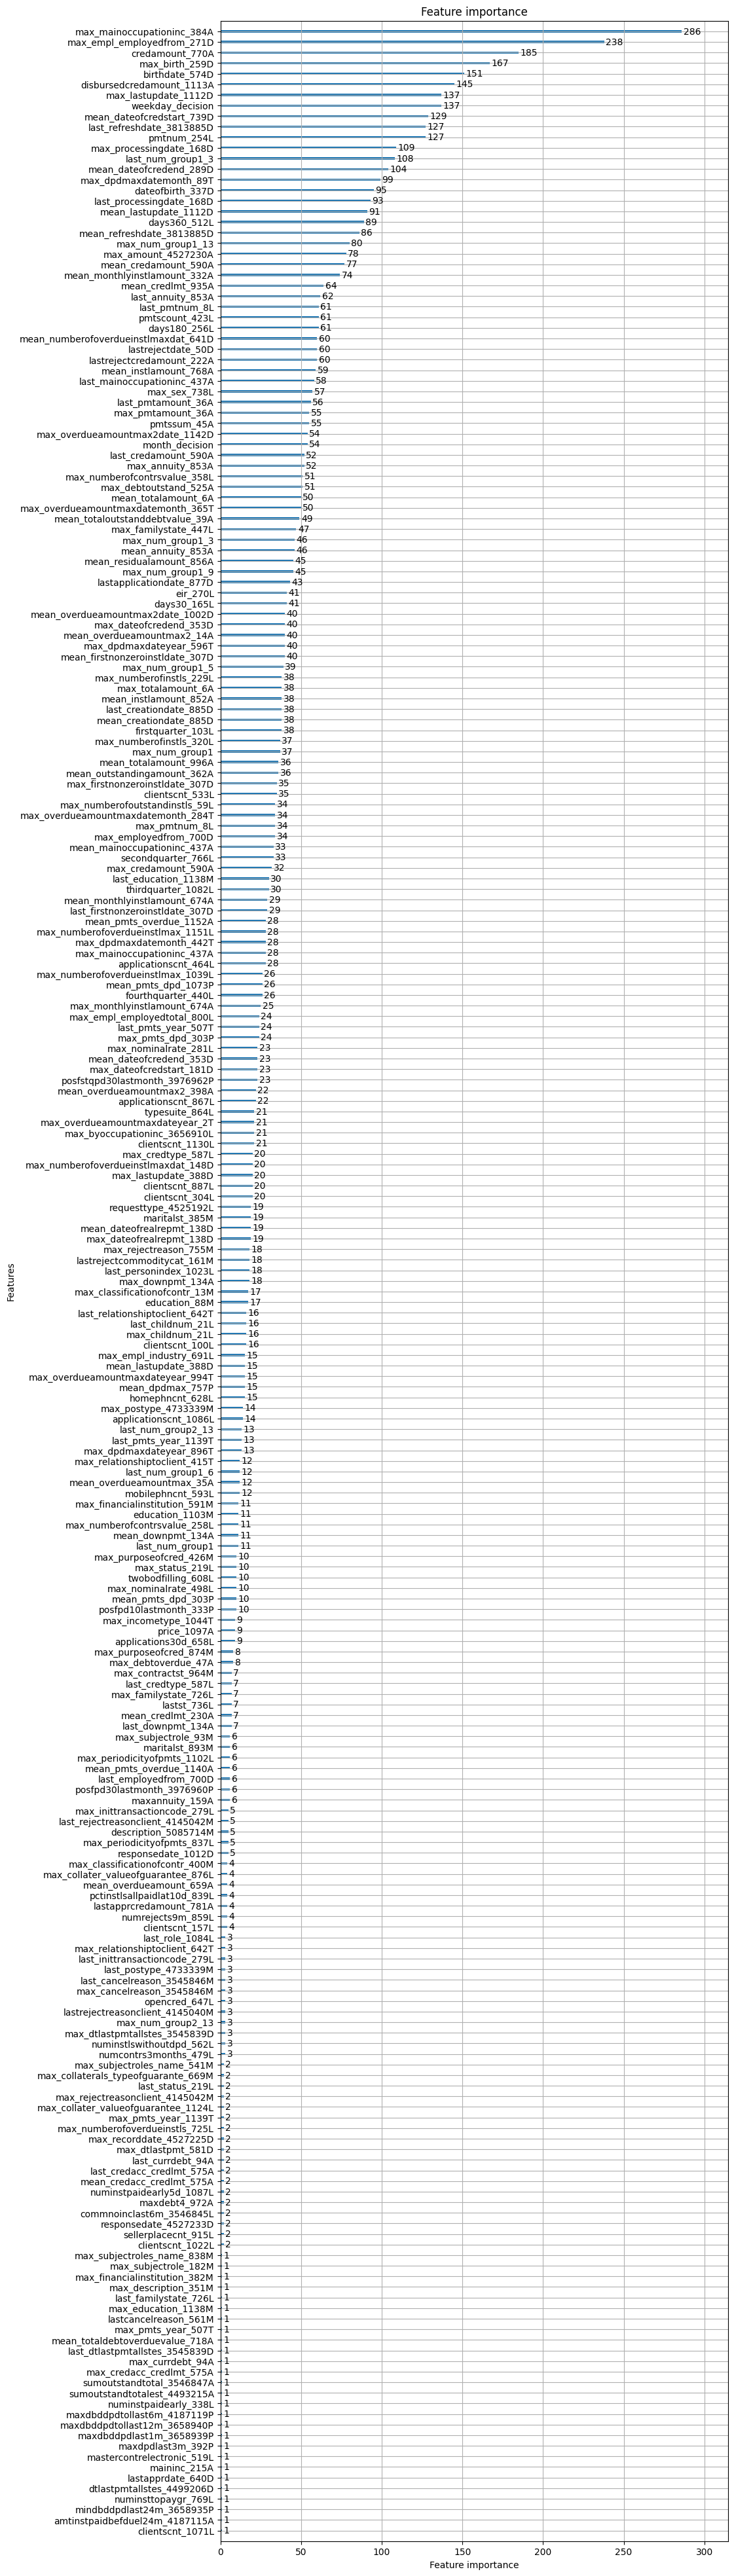

In [21]:
lgb.plot_importance(fitted_models[4], importance_type="split", figsize=(10,50))
plt.show()

In [22]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models)

# **Here is the online weight calculation code in the effect and time of a piece of code, forgive me for forgetting the original author's notebook

In [23]:
from sklearn.metrics import roc_auc_score
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

def stratified_sample(df, week_num_col='WEEK_NUM', target_col='target', n_samples=1000):
    """
    Perform stratified sampling to ensure each combination of week number and target is represented.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - week_num_col: Name of the column containing week numbers.
    - target_col: Name of the column containing target values.
    - n_samples: Total number of samples to return.
    
    Returns:
    - A sampled pandas DataFrame with n_samples (if possible) ensuring representation of each group.
    """
    
    samples_per_group = max(1, n_samples // df.groupby([week_num_col, target_col]).ngroups)
    
    sampled_df = df.groupby([week_num_col, target_col]).apply(
        lambda x: x.sample(n=min(samples_per_group, len(x)), replace=True if len(x) < samples_per_group else False)
    ).reset_index(drop=True)
    
    if len(sampled_df) < n_samples:
        additional_samples = n_samples - len(sampled_df)
        additional_sampled_df = df.sample(n=additional_samples, replace=True)
        sampled_df = pd.concat([sampled_df, additional_sampled_df], ignore_index=True)
    
    return sampled_df
class WeightedVotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators, num_iters=100, scale=0.1):
        super().__init__()
        self.estimators = estimators
        self.weights = np.ones(len(self.estimators)) / len(self.estimators)
        
        self.num_iters = num_iters
        self.scale = scale
        
    def fit(self, X, y=None):
        
        X["score"] = self.predict_proba(X.drop(columns=["target", "WEEK_NUM"]))[:, 1]
        last_gini = gini_stability(X)
        
        for itr in range(self.num_iters):
            idx = np.random.randint(len(self.estimators))
            
            new_weights = self.weights
            
            # choose weight to change
            delta = np.random.normal(loc=0.0, scale=self.scale)
            if new_weights[idx] + delta >= 0:
                new_weights[idx] += delta
            new_weights = new_weights / new_weights.sum()
            
            old_weights = self.weights
            self.weights = new_weights
            
            # compute new gini score
            X["score"] = self.predict_proba(X.drop(columns=["target",  "WEEK_NUM", "score"]))[:, 1]
            new_gini = gini_stability(X)
            
            print(f"Iteration {itr + 1}/{self.num_iters} || last_gini: {last_gini:.5f} || new_gini: {new_gini:.5f}")
            
            # choose to update the weights or not
            if new_gini < last_gini:
                # return old weights because old gini was better
                self.weights = old_weights
            else:
                # accept new weights and change current gini
                last_gini = new_gini
            
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.sum(y_preds * self.weights[:, None], axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        #print(self.weights[:, None, None])
        return np.sum(y_preds * self.weights[:, None, None], axis=0)

# This is to delete the week with only one type of data to avoid errors in calculating the auc

In [24]:
dt=pd.DataFrame()
dt["target"]=y
dt["WEEK_NUM"]=weeks
dt=dt.groupby("WEEK_NUM").sum()
todrop=list(dt[dt['target']==0] .index)
for week in todrop:
    df_train = df_train[weeks!=week]
    y = y[weeks!=week]
    weeks = weeks[weeks!=week]
df_train["target"]=y
df_train["WEEK_NUM"]=weeks

In [25]:

weighted_model = WeightedVotingModel(fitted_models, num_iters=40, scale=0.1)
df_almost_val = stratified_sample(df_train, n_samples=n_samples)
weighted_model.fit(df_almost_val)
weighted_model.weights
small_train = stratified_sample(df_train, n_samples=n_samples)

small_train['score'] = weighted_model.predict_proba(small_train.drop(columns=["target", "WEEK_NUM"]))[:, 1]
print(f"n_samples: {n_samples} || gini_stability: {gini_stability(small_train)}")
df_test = df_test.drop(columns=["WEEK_NUM"])
df_test = df_test.set_index("case_id")
y_pred = pd.Series(weighted_model.predict_proba(df_test)[:, 1], index=df_test.index)
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred
df_subm.to_csv("submission.csv")
df_subm

Iteration 1/40 || last_gini: 0.78561 || new_gini: 0.78479
Iteration 2/40 || last_gini: 0.78561 || new_gini: 0.78668
Iteration 3/40 || last_gini: 0.78668 || new_gini: 0.78668
Iteration 4/40 || last_gini: 0.78668 || new_gini: 0.78512
Iteration 5/40 || last_gini: 0.78668 || new_gini: 0.78512
Iteration 6/40 || last_gini: 0.78668 || new_gini: 0.77976
Iteration 7/40 || last_gini: 0.78668 || new_gini: 0.77976
Iteration 8/40 || last_gini: 0.78668 || new_gini: 0.77863
Iteration 9/40 || last_gini: 0.78668 || new_gini: 0.77863
Iteration 10/40 || last_gini: 0.78668 || new_gini: 0.77868
Iteration 11/40 || last_gini: 0.78668 || new_gini: 0.78030
Iteration 12/40 || last_gini: 0.78668 || new_gini: 0.78062
Iteration 13/40 || last_gini: 0.78668 || new_gini: 0.78072
Iteration 14/40 || last_gini: 0.78668 || new_gini: 0.77719
Iteration 15/40 || last_gini: 0.78668 || new_gini: 0.77724
Iteration 16/40 || last_gini: 0.78668 || new_gini: 0.77724
Iteration 17/40 || last_gini: 0.78668 || new_gini: 0.77722
Iterat

,score
case_id,
57543,0.042244
57549,0.079723
57551,0.035331
57552,0.063041
57569,0.074995
57630,0.033850
57631,0.113341
57632,0.103937
57633,0.075732
